# Google Drive Connection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fetch Dataset from Google Drive

### Move datasets to Colab (VM) workspace from Google Drive

In [2]:
!cp /content/drive/MyDrive/ece528/dataset_np.npy /content/dataset_np.npy
!cp /content/drive/MyDrive/ece528/lidar_dataset.zip /content/lidar_dataset.zip

## Unzip Lidar Image Dataset

In [ ]:
!unzip /content/lidar_dataset.zip

In [4]:
# Change Directory to Colab Workspace
%cd /content/

/content


# Code


## Import Libraries

In [5]:
import os
import numpy as np
import pandas as pd
import scipy.io as scipyio
import matplotlib.pyplot as plt
from scipy.io import loadmat
import PIL
from PIL import Image
import pathlib
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Flatten
from keras import utils

## Path Variables

In [6]:
dataset_path = r"/content/dataset_np.npy"
data_dir = r"/content/content/lidar_dataset"

## Load Dataset

In [7]:
dataset = np.load(dataset_path, allow_pickle=True)

In [8]:
# dataset 
test, train, valid = dataset 
_, test_X, test_y = test 
_, train_X, train_y = train 
_, valid_X, valid_y = valid

## Convertion Functions

### Vector Convertions

In [9]:
def float_to_row(value):
  result = []
  limit = int(np.round((460 / 17) * value))
  for _ in range(limit):
    result.append([255, 255, 255])
  for _ in range(460 - limit):
    result.append([0, 0, 0])
  return result

def vector_to_image(arr):
  result_matrix = []
  for value in arr:
    result_matrix.append(float_to_row(value))
  return np.array(result_matrix)

#### Debug (Vector Convertions)

In [10]:
y = 3.141592653589793238
print(np.shape(float_to_row(y)))

(460, 3)


In [11]:
vector = train_X[42][:,0]

In [12]:
img_arr = vector_to_image(vector)

In [13]:
print(np.shape(img_arr))

(460, 460, 3)


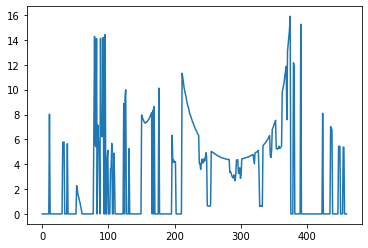

In [14]:
x = np.arange(0, 460)
plt.figure()
plt.plot(x, vector)
plt.show()

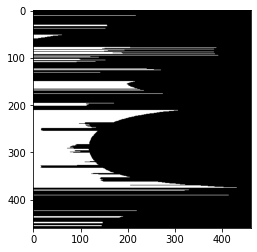

In [15]:
plt.figure()
plt.imshow(img_arr, cmap='gray')
plt.show()

### Matrix Convertions

In [16]:
def matrix_to_img(matrix):
  return Image.fromarray(matrix.astype('uint8'))

def image_resize(img, target):
  image = img.resize(target)
  image = utils.img_to_array(image)
  return matrix_to_img(image)

def convert_matrix_to_img(matrix):
   vector = matrix[:,0]
   img_from_vector = vector_to_image(vector)
   return matrix_to_img(img_from_vector)

def convert_to_img(matricies, target=(256,256)):
  result = []
  for index in range(len(matricies)):
      matrix = matricies[index]
      img = convert_matrix_to_img(matrix)
      img_rs = image_resize(img, target)
      result.append(img_rs)
  return result  

def convert_and_save(X, y, save_dir, prefix, i):
  img = convert_matrix_to_img(X)
  img_rs = image_resize(img, target=(256,256))
  save_path = create_dir(save_dir, get_index_name(y))
  img_name = os.path.join(save_path, f"img_{prefix}_{i}.png")
  img_rs.save(img_name)

#### Debug (Matrix Convertions

In [17]:
train_X_sample = train_X[0:5]
train_X_img = convert_to_img(train_X_sample)

256 256


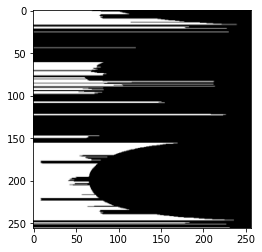

256 256


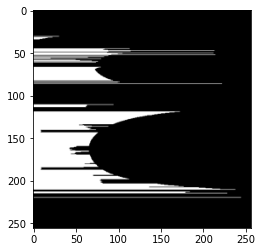

256 256


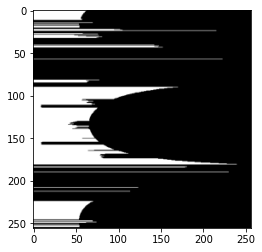

256 256


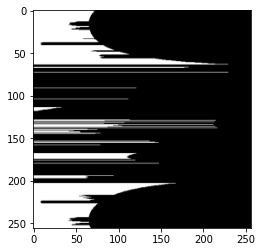

256 256


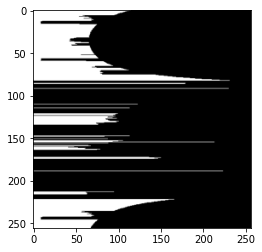

In [18]:
for img in train_X_img:
  print(img.width, img.height)
  plt.figure()
  plt.imshow(img)
  plt.show()

## Deep Learning Model Training

### Check GPU type


In [19]:
!nvidia-smi

Sun Jan 22 19:26:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Config

In [20]:
img_size = (256, 256)
batch_size = 10 
num_epochs = 30

#### Train Dataset Split

In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=761,
  label_mode="categorical",
  image_size=img_size,
  batch_size=batch_size)

Found 5371 files belonging to 62 classes.
Using 4297 files for training.


#### Validation Dataset Split

In [22]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=761,
  label_mode="categorical",
  image_size=img_size,
  batch_size=batch_size)

Found 5371 files belonging to 62 classes.
Using 1074 files for validation.


#### Output Classes

In [23]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("class names:", class_names)
print("number of classes:", num_classes)

class names: ['index_10', 'index_11', 'index_12', 'index_13', 'index_14', 'index_15', 'index_16', 'index_17', 'index_18', 'index_19', 'index_2', 'index_20', 'index_21', 'index_22', 'index_23', 'index_24', 'index_25', 'index_26', 'index_27', 'index_28', 'index_29', 'index_3', 'index_30', 'index_31', 'index_32', 'index_33', 'index_34', 'index_35', 'index_36', 'index_37', 'index_38', 'index_39', 'index_4', 'index_40', 'index_41', 'index_42', 'index_43', 'index_44', 'index_45', 'index_46', 'index_47', 'index_48', 'index_49', 'index_5', 'index_50', 'index_51', 'index_52', 'index_53', 'index_54', 'index_55', 'index_56', 'index_57', 'index_58', 'index_59', 'index_6', 'index_60', 'index_61', 'index_62', 'index_63', 'index_7', 'index_8', 'index_9']
number of classes: 62


#### Print Random Samples from Dataset

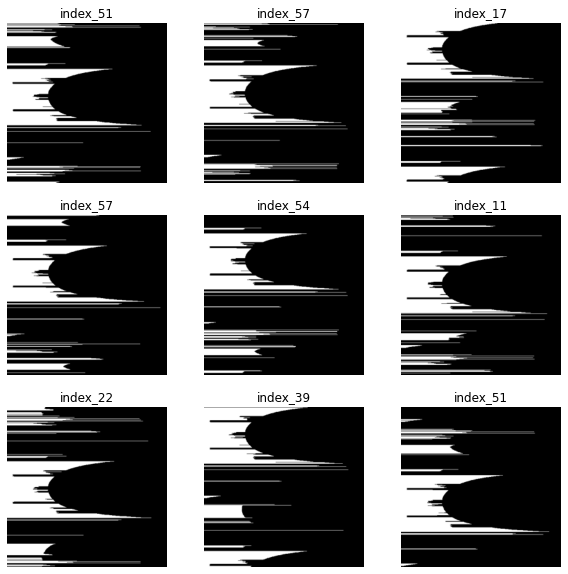

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = class_names[labels[i].numpy().tolist().index(1)]
        plt.title(title)
        plt.axis("off")

#### Model Strucutre

##### Load Pretrained Model ResNet50 

In [25]:
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',
                   classes=num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

94765736/94765736 [==============================] - 3s 0us/step


In [26]:
pretrained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

##### Create Model

In [27]:
resnet_model = Sequential()
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(num_classes, activation='softmax'))

In [28]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 62)                31806     
                                                                 
Total params: 24,668,606
Trainable params: 1,080,894
Non-trainable params: 23,587,712
_________________________________________________________________


In [29]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


##### Train the Model

In [30]:
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=num_epochs)

Epoch 1/30
430/430 [==============================] - 38s 63ms/step - loss: 3.5662 - accuracy: 0.1478 - val_loss: 3.2155 - val_accuracy: 0.1741
Epoch 2/30
430/430 [==============================] - 26s 60ms/step - loss: 2.8740 - accuracy: 0.2353 - val_loss: 2.6971 - val_accuracy: 0.2728
Epoch 3/30
430/430 [==============================] - 26s 60ms/step - loss: 2.5389 - accuracy: 0.2890 - val_loss: 2.4860 - val_accuracy: 0.2747
Epoch 4/30
430/430 [==============================] - 26s 60ms/step - loss: 2.3376 - accuracy: 0.3184 - val_loss: 2.4132 - val_accuracy: 0.2775
Epoch 5/30
430/430 [==============================] - 26s 61ms/step - loss: 2.1992 - accuracy: 0.3363 - val_loss: 2.3174 - val_accuracy: 0.2961
Epoch 6/30
430/430 [==============================] - 26s 61ms/step - loss: 2.1011 - accuracy: 0.3540 - val_loss: 2.2302 - val_accuracy: 0.3119
Epoch 7/30
430/430 [==============================] - 27s 62ms/step - loss: 2.0463 - accuracy: 0.3600 - val_loss: 2.1625 - val_accuracy:

##### Plot the Model Accuracy 

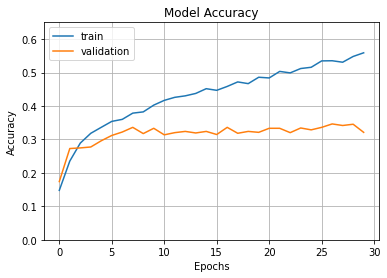

In [31]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.0, ymax=0.65)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

##### Save the Model

In [32]:
resnet_model.save('/content/lidar_model.h5')

### Test and Analysis

#### Prediction Functions

In [33]:
def predict_img(model, img):
  img = np.expand_dims(img, axis=0)
  pred = model.predict(img)
  output_class=class_names[np.argmax(pred)]
  return output_class

In [34]:
def top_n_max_indices(arr, n):
  return np.argpartition(arr, -n)[-n:]

In [35]:
def predict_img_slice(model, img, n):
  img = np.expand_dims(img, axis=0)
  pred = model.predict(img)
  pred_val = pred[0,:]
  output_classes_idx = top_n_max_indices(pred_val, n)
  class_names_np = np.array(class_names)
  output_classes = class_names_np[output_classes_idx]
  return output_classes

In [36]:
test_X_imgs = convert_to_img(test_X)

##### Debug Test

In [37]:
predict_img(resnet_model, test_X_imgs[0])
print("actual class is:", test_y[0])

1/1 [==============================] - 1s 1s/step
actual class is: 14


In [38]:
predict_img_slice(resnet_model, test_X_imgs[0], 2)

1/1 [==============================] - 0s 22ms/step


array(['index_13', 'index_14'], dtype='<U8')

#### Calculate Top N Score

##### Calculator Functions

In [39]:
def calculate_top1_score(model, imgs, y):
  correct = 0
  for idx, img in enumerate(imgs):
    pred_class = predict_img(model, img)
    pred_val = int(pred_class.split("_")[1])
    if pred_val == y[idx]:
      correct = correct + 1
  return correct / len(imgs)

In [40]:
def calculate_top_n_score(model, imgs, y, n):
  correct = 0
  for idx, img in enumerate(imgs):
    top_n = predict_img_slice(model, img, n)
    top_n_val = list(map(lambda v: int(v.split("_")[1]), top_n))
    if y[idx] in top_n_val:
      correct = correct + 1
  return correct / len(imgs)

##### Benchmarks

In [ ]:
top1_score = calculate_top1_score(resnet_model, test_X_imgs, test_y)

In [ ]:
top2_score = calculate_top_n_score(resnet_model, test_X_imgs, test_y, 2)

In [ ]:
top3_score = calculate_top_n_score(resnet_model, test_X_imgs, test_y, 3)

In [ ]:
top5_score = calculate_top_n_score(resnet_model, test_X_imgs, test_y, 5)

##### Results

In [45]:
print("top1 score:", top1_score)
print("top2 score:", top2_score)
print("top3 score:", top3_score)
print("top5 score:", top5_score)

top1 score: 0.3305227655986509
top2 score: 0.524451939291737
top3 score: 0.6492411467116358
top5 score: 0.8296795952782462


# Pre-processing

## Convert dataset Matlab (.mat) to NumPy (.npy)

### Move development dataset to Colab (VM) workspace from Google Drive

In [ ]:
!cp /content/drive/MyDrive/ece528/development_dataset /content/development_dataset

### Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.io as scipyio
from scipy.io import loadmat

### Path Variable

In [ ]:
src_path = r"/content/development_dataset"

### Convertion Functions

In [ ]:
def get_csv_name(fullname):
  return fullname.split("_")[-1].replace(".csv", "")

In [ ]:
def mat_to_np(mat_path):
  # print(mat_path) #debug 
  return loadmat(mat_path)["data"]

In [ ]:
def read_entire_csv(src_path, file_path, x_label="unit1_lidar_1", y_label="beam_index_1"):
  # desired format = name, X, y
  csv_path = os.path.join(src_path, file_path)
  name = get_csv_name(csv_path)
  df = pd.read_csv(csv_path)
  x_paths = df[x_label].values
  y = df[y_label].values  
  X = np.array(list(map(lambda x_path: mat_to_np(os.path.join(src_path, x_path)) , x_paths)))
  return np.array([name, X, y])

In [ ]:
def load_data_from_csv(path):
  csv_file_list = [file for file in os.listdir(path) if file.endswith('csv')]
  return np.array(list(map(lambda csv_file_path: read_entire_csv(path, csv_file_path), csv_file_list)))

In [ ]:
def sort_by_angle(nparray):
  return np.array(list(map(lambda cur: cur[cur[:, 1].argsort()], nparray)))

In [ ]:
# Convert dataset and save as npy
dataset = load_data_from_csv(src_path)
np.save('dataset_np', dataset)

## Convert NumPy Dataset to Image Dataset

### Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.io as scipyio
import matplotlib.pyplot as plt
from scipy.io import loadmat
from PIL import Image
from keras import utils

### Load npy dataset

In [ ]:
# Load npy dataset
dataset = np.load(dataset_path, allow_pickle=True)

In [ ]:
# dataset 
test, train, valid = dataset 
_, test_X, test_y = test 
_, train_X, train_y = train 
_, valid_X, valid_y = valid

### Convertion Functions

In [ ]:
target_dir = r"/content/lidar_dataset"

In [ ]:
def create_dir(target, name):
  path_dir = os.path.join(target, name)
  if not os.path.exists(path_dir):
    os.makedirs(path_dir)
  return path_dir

In [ ]:
def get_index_name(y):
  return f"index_{y}"

In [ ]:
for i in range(len(train_X)):
  print(f"current index (train): {i}")
  convert_and_save(train_X[i], train_y[i], target_dir, "train", i)

for i in range(len(valid_X)):
  print(f"current index (valid): {i}")
  convert_and_save(valid_X[i], valid_y[i], target_dir, "valid", i)

In [ ]:
# Debug
os.listdir(target_dir)

#### Zip Image Dataset and Copy to Google Drive

In [ ]:
!zip -r /content/lidar_dataset.zip /content/lidar_dataset/

In [ ]:
!cp /content/lidar_dataset.zip /content/drive/MyDrive/ece528/lidar_dataset.zip